In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
os.chdir('/Users/khavya/Box/MS - Financial Engineering/Fall 2020/FIN566 - Algorithmic Market Microstructure')
import matplotlib.pyplot as plt
import seaborn as sns

import collections
from collections import defaultdict
import scipy.stats as st
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

plt.style.use('seaborn-ticks')
pd.set_option('display.max_columns', None)

In [2]:
# Loading the data (MSFT, SPY, AMZN, AAPL, INTL, JPM) 
wholedf = pd.read_csv('six_components.csv')
wholedf.sort_values(['ticker','Collection_time'])

# Deleting the unwanted rows generated
del wholedf['Unnamed: 0']
del wholedf['Unnamed: 0.1']

# Finding the unique tickers in the data
unique_tickers = wholedf.ticker.unique()
print(unique_tickers)

['AAPL' 'AMZN' 'INTL' 'JPM' 'MSFT' 'SPY']


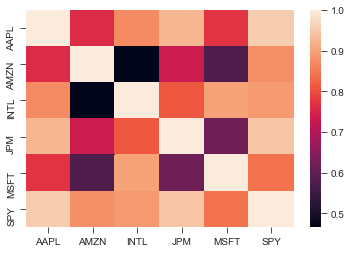

In [3]:
# Correlation for the six components (With whole data from October 1 to November 1)
correlation = []
for i in range(len(unique_tickers)):
    corr = []
    for j in range(len(unique_tickers)):
        join_left = wholedf[wholedf['ticker'] == unique_tickers[i]]
        join_right = wholedf[wholedf['ticker'] == unique_tickers[j]]
        result = pd.merge(join_left, join_right, on = 'Collection_time', how = 'outer')
        result = result.sort_values('Collection_time')
        result = result.fillna(method = 'pad')
        correl = result[['price_x', 'price_y']].corr()
        corr.append(correl.iloc[0,1])
    correlation.append(corr)

# Adding the correlation values into a DataFrame
corr_matrix = pd.DataFrame(correlation)
corr_matrix.columns = unique_tickers
corr_matrix.index = unique_tickers

# Plotting the heatmap (Correlation Matrix)
sns.heatmap(corr_matrix, cbar=True)
plt.show()

In [4]:
####### Source: Yong Xie's Code ########

# Setting up the scene for regression
window = pd.Timedelta('0 days 00:00:10.000000')
regression_data = pd.merge(wholedf[wholedf['ticker']=='SPY'], wholedf[wholedf['ticker']=='AAPL'], 
                           on = 'Collection_time', how = 'outer', suffixes = ['_SPY', '_AAPL'])
regression_data = regression_data.sort_values('Collection_time')
regression_data = regression_data.fillna(method = 'pad')
combine = regression_data.fillna(method = 'bfill')
combine['Collection_time'] = pd.to_datetime(combine['Collection_time'])

In [5]:
# Calculating future returns
combine_values = combine.values

component_return = np.zeros((combine_values.shape[0], 1))
etf_return = np.zeros((combine_values.shape[0], 1))

n = combine_values.shape[0]
for i in range(n):
    j = i + 1
    while j < n and combine_values[j,0] - combine_values[i,0] < window:
        j += 1
    if j >= n:
        etf_return[i, 0] = np.nan
        component_return[i, 0]= np.nan
    else:
        etf_return[i, 0] = combine_values[j, 5]/combine_values[i, 5] - 1
        component_return[i, 0] = combine_values[j, 12]/combine_values[i, 12] - 1
        
combine['Return_SPY'] = etf_return
combine['Return_AAPL'] = component_return

In [6]:
## calculate features
windows = {'1': pd.Timedelta('0 days 00:00:01.000000'),
           '5': pd.Timedelta('0 days 00:00:05.000000'),
           '10': pd.Timedelta('0 days 00:00:10.000000'),
           '30': pd.Timedelta('0 days 00:00:30.000000'),
           '60': pd.Timedelta('0 days 00:01:00.000000'),
           '90': pd.Timedelta('0 days 00:01:30.000000')}

combine_values = combine.values
n = combine_values.shape[0]

for k, window in windows.items():
    component_return = np.zeros((combine_values.shape[0], 1))
    etf_return = np.zeros((combine_values.shape[0], 1))
    
    for i in range(n):
        j = i - 1
        while j >=0 and combine_values[i,0] - combine_values[j,0] < window:
            j -= 1
        if j < 0:
            etf_return[i, 0] = np.nan
            component_return[i, 0]= np.nan
        else:
            etf_return[i, 0] = combine_values[i, 5]/combine_values[j, 5] - 1
            component_return[i, 0] = combine_values[i, 12]/combine_values[j, 12] - 1

    combine['Return_SPY_'+k] = etf_return
    combine['Return_AAPL_'+k] = component_return

In [7]:
# SPY - Dependent variable
combine_valid = combine.dropna(how='any', axis=0)

x_cols_aapl = []
x_cols_spy = []
for k, _ in windows.items():
    x_cols_aapl.append('Return_SPY_'+k)
    x_cols_spy.append('Return_AAPL_'+k)
x_cols = x_cols_aapl + x_cols_spy

y = combine_valid.Return_SPY.to_list()
x = combine_valid[x_cols]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     600.2
Date:                Sun, 13 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:29:33   Log-Likelihood:             1.7795e+06
No. Observations:              252683   AIC:                        -3.559e+06
Df Residuals:                  252670   BIC:                        -3.559e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.087e-06   4.21e-07     -4.

In [8]:
# AAPL - Dependent variable
combine_valid = combine.dropna(how='any', axis=0)

y = combine_valid.Return_AAPL.to_list()
x = combine_valid[x_cols]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     1555.
Date:                Sun, 13 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:29:40   Log-Likelihood:             1.6232e+06
No. Observations:              252683   AIC:                        -3.246e+06
Df Residuals:                  252670   BIC:                        -3.246e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -5.512e-07   7.82e-07     -0.